In [1]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
import boto3

from dotenv import load_dotenv

In [2]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env


In [61]:
working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Working Directory: /home/lakishadavid/computational_genetic_genealogy
Data Directory: /home/lakishadavid/computational_genetic_genealogy/data
References Directory: /home/lakishadavid/computational_genetic_genealogy/references
Results Directory: /home/lakishadavid/computational_genetic_genealogy/results
Utils Directory: /home/lakishadavid/computational_genetic_genealogy/utils
The current directory is /home/lakishadavid/computational_genetic_genealogy


In [4]:
def configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO"):
    """
    Configure logging for both file and console handlers.

    Args:
        log_filename (str): Path to the log file where logs will be written.
        log_file_debug_level (str): Logging level for the file handler.
        console_debug_level (str): Logging level for the console handler.
    """
    # Create a root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)  # Capture all messages at the root level

    # Convert level names to numeric levels
    file_level = getattr(logging, log_file_debug_level.upper(), logging.INFO)
    console_level = getattr(logging, console_debug_level.upper(), logging.INFO)

    # File handler: Logs messages at file_level and above to the file
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(file_level)
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)

    # Console handler: Logs messages at console_level and above to the console
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(console_level)
    console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(console_formatter)

    # Add handlers to the root logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
def clear_logger():
    """Remove all handlers from the root logger."""
    logger = logging.getLogger()
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)

In [5]:
log_filename = os.path.join(results_directory, "lab8.log")
print(f"The Lab 8 log file is located at {log_filename}.")

# Ensure the results_directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Check if the file exists; if not, create it
if not os.path.exists(log_filename):
    with open(log_filename, 'w') as file:
        pass  # The file is now created.
    
clear_logger() # Clear the logger before reconfiguring it
configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO")

The Lab 8 log file is located at /home/lakishadavid/computational_genetic_genealogy/results/lab8.log.


Go to Lab0_Code_Environment and run the set of code cells for **Install R** and **Install liftover**.

Also, rerun `poetry install --no-root` to install new packages.

Ensure rpy2 Jupyter Extension is Loaded by running the next cell.

In [7]:
%load_ext rpy2.ipython

2025-02-27 08:44:41,903 - INFO - cffi mode is CFFI_MODE.ANY
2025-02-27 08:44:41,934 - INFO - R home found: /usr/lib/R
2025-02-27 08:44:42,123 - INFO - R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
2025-02-27 08:44:42,124 - INFO - LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
2025-02-27 08:44:42,126 - INFO - Default options to initialize R: rpy2, --quiet, --no-save
2025-02-27 08:44:42,285 - INFO - R is already initialized. No need to initialize.


Now you can use cell magic for R.

In [ ]:
%%R

x <- c(1, 2, 3, 4, 5)
mean(x)

In [12]:
%%R
.libPaths(c("/usr/local/lib/R/site-library", "/usr/lib/R/site-library", "/usr/lib/R/library"))
print(.libPaths())


[1] "/usr/local/lib/R/site-library" "/usr/lib/R/site-library"      
[3] "/usr/lib/R/library"           


In [19]:
%%R
# Create the personal library directory if it doesn't already exist
dir.create("~/R/library/", showWarnings = FALSE, recursive = TRUE)

# Add this line to your ~/.Rprofile so R always looks in ~/R/library/ first
writeLines('.libPaths(c("~/R/library/", .libPaths()))', con="~/.Rprofile")

# (Optional) Show the contents of ~/.Rprofile to confirm
cat(readLines("~/.Rprofile"), sep="\n")

.libPaths(c("~/R/library/", .libPaths()))


**Restart your kernel**

Once restarted, R will automatically load the updated .Rprofile.

In [8]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Verify that R recognizes `~/R/library/`

In [9]:
%%R
.libPaths()

[1] "/home/lakishadavid/R/library"  "/usr/local/lib/R/site-library"
[3] "/usr/lib/R/site-library"       "/usr/lib/R/library"           


In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [11]:
%%R

install.packages("pedsuite", repos="https://cloud.r-project.org/")
library(pedsuite)
print("pedsuite loaded successfully!")

* installing *source* package ‘pedsuite’ ...
** package ‘pedsuite’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (pedsuite)


[1] "pedsuite loaded successfully!"


Installing package into ‘/home/lakishadavid/R/library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/pedsuite_1.3.1.tar.gz'
Content type 'application/x-gzip' length 1013145 bytes (989 KB)
downloaded 989 KB


The downloaded source packages are in
	‘/tmp/RtmpihcYsy/downloaded_packages’
Loading required package: forrel
Loading required package: pedtools
Loading required package: pedprobr
Loading required package: ribd
Loading required package: verbalisr


## Create Genetic Family Tree

Now that you have R setup on your system, let's proceed with creating a genetic family tree.

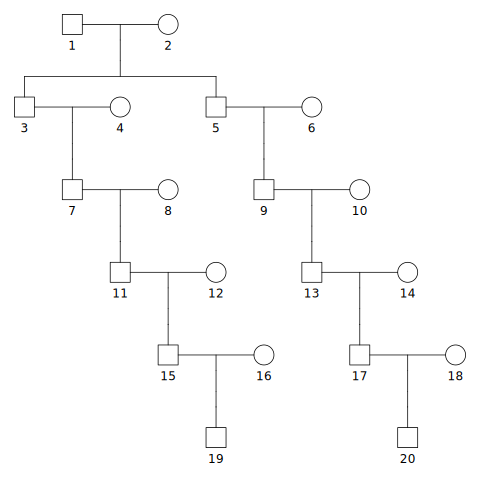

In [12]:
%%R

# Generate a cousin pedigree of degree 4
# We start with a base structure called cousinPed
x = cousinPed(degree = 4)

# There are other base structures to choose from.

plot(x)

# Notice in the pedigree plot that each individual has an assigned number.
# The assigned numbers for each individual is the identifier.
# Here, I am adding children using the identifiers.
# Note that nch is number of children.
# Note that sex = 1 is male and sex = 2 is female.
# Note that males are squares and females are circles.

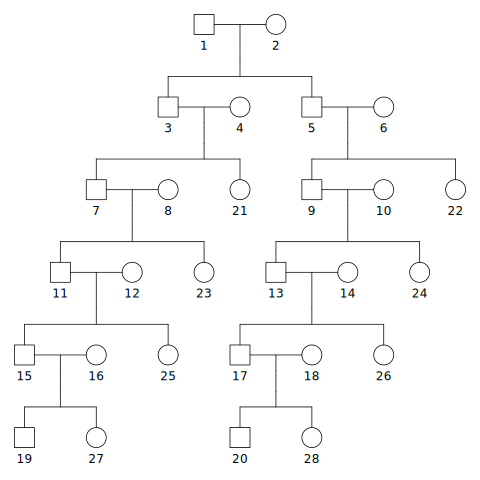

In [13]:
%%R

# Now that you have pedigree x, you can make adjustments.

# In this first adjustment, I am calling individual number 3 the father.
# I am calling individual number 4 the mother.
# Then I am adding 1 female child.
x = addChildren(x, father = 3, mother = 4, nch = 1, sex = 2)

x = addChildren(x, father = 5, mother = 6, nch = 1, sex = 2)
x = addChildren(x, father = 7, mother = 8, nch = 1, sex = 2)
x = addChildren(x, father = 9, mother = 10, nch = 1, sex = 2)
x = addChildren(x, father = 11, mother = 12, nch = 1, sex = 2)
x = addChildren(x, father = 13, mother = 14, nch = 1, sex = 2)
x = addChildren(x, father = 15, mother = 16, nch = 1, sex = 2)
x = addChildren(x, father = 17, mother = 18, nch = 1, sex = 2)

plot(x)

# Notice how the pedigree changed.
# Take a moment to understand the changes that you made.

Creating new father: 29
Creating new father: 31
Creating new father: 33
Creating new father: 35
Creating new father: 37
Creating new father: 39


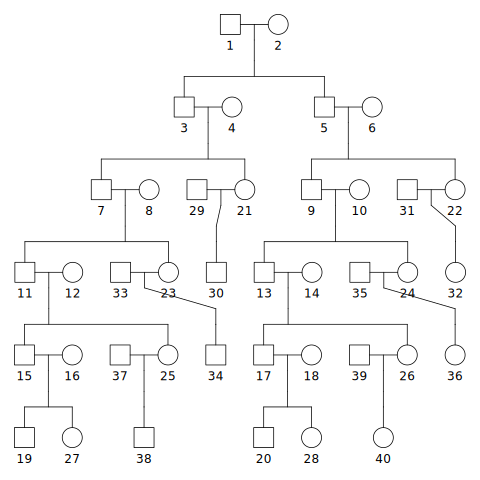

In [14]:
%%R

# I continue to make adjustments until I get the pedigree I want.

x = addChildren(x, mother = 21, nch = 1, sex = 1)
x = addChildren(x, mother = 22, nch = 1, sex = 2)
x = addChildren(x, mother = 23, nch = 1, sex = 1)
x = addChildren(x, mother = 24, nch = 1, sex = 2)

x = addChildren(x, mother = 25, nch = 1, sex = 1)
x = addChildren(x, mother = 26, nch = 1, sex = 2)

plot(x)

Creating new mother: 41
Creating new mother: 43
Creating new father: 45
Creating new father: 47


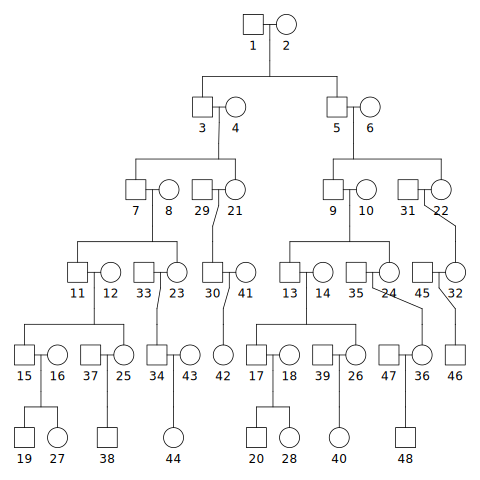

In [15]:
%%R

# I continue to make adjustments until I get the pedigree I want.

x = addChildren(x, father = 30, nch = 1, sex = 2)
x = addChildren(x, father = 34, nch = 1, sex = 2)
x = addChildren(x, mother = 32, nch = 1, sex = 1)
x = addChildren(x, mother = 36, nch = 1, sex = 1)

plot(x)

Creating new father: 49
Creating new mother: 51


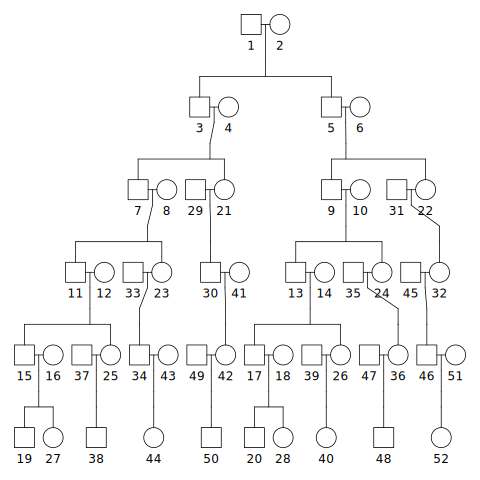

In [16]:
%%R

# I continue to make adjustments until I get the pedigree I want.

x = addChildren(x, mother = 42, nch = 1, sex = 1)
x = addChildren(x, father = 46, nch = 1, sex = 2)

plot(x)

# With this final adjustment, I have satisfied with the pedigree.
# Think about other adjustments that you could do.
# For example, how might you represent a man with three wives, each with a certain number of children?

In [17]:
%%R

# Print the pedigree to check the structure

print(x)

 id fid mid sex
  1   *   *   1
  2   *   *   2
  3   1   2   1
  4   *   *   2
  5   1   2   1
  6   *   *   2
  7   3   4   1
  8   *   *   2
  9   5   6   1
 10   *   *   2
 11   7   8   1
 12   *   *   2
 13   9  10   1
 14   *   *   2
 15  11  12   1
 16   *   *   2
 17  13  14   1
 18   *   *   2
 19  15  16   1
 20  17  18   1
 21   3   4   2
 22   5   6   2
 23   7   8   2
 24   9  10   2
 25  11  12   2
 26  13  14   2
 27  15  16   2
 28  17  18   2
 29   *   *   1
 30  29  21   1
 31   *   *   1
 32  31  22   2
 33   *   *   1
 34  33  23   1
 35   *   *   1
 36  35  24   2
 37   *   *   1
 38  37  25   1
 39   *   *   1
 40  39  26   2
 41   *   *   2
 42  30  41   2
 43   *   *   2
 44  34  43   2
 45   *   *   1
 46  45  32   1
 47   *   *   1
 48  47  36   1
 49   *   *   1
 50  49  42   1
 51   *   *   2
 52  46  51   2


Extract the pedigree created by pedsuite to a pandas dataframe.

In [52]:
%%R -o fam_df

# Extract data using indexing (modify indices if needed)
individual_id <- as.character(x$ID)
father_id <- ifelse(x$FIDX == "*", 0, x$FIDX)
mother_id <- ifelse(x$MIDX == "*", 0, x$MIDX)
sex <- as.character(x$SEX)

# Create data frame
fam_df <- data.frame(
  individual_id = individual_id,
  father_id = father_id,
  mother_id = mother_id,
  sex = sex
)

Inspect the dataframe to make sure that it looks as intended.

In [53]:
fam_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 1 to 52
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   individual_id  52 non-null     object
 1   father_id      52 non-null     int32 
 2   mother_id      52 non-null     int32 
 3   sex            52 non-null     object
dtypes: int32(2), object(2)
memory usage: 1.6+ KB


In [54]:
# Inspect the first 8 rows.
# Compare them to the pedsuite pedigree.
# (Note that we are using Python.)

fam_df.head(8)

,individual_id,father_id,mother_id,sex
1,1,0,0,1
2,2,0,0,2
3,3,1,2,1
4,4,0,0,2
5,5,1,2,1
6,6,0,0,2
7,7,3,4,1
8,8,0,0,2


In [55]:
# Insert a default family ID column at the beginning
fam_df.insert(0, "family_id", "FAM")

# Append a phenotype column with a default value (e.g., -9 for missing phenotype)
fam_df["phenotype"] = -9

# Rename the columns to match the required headers:
# FAM_ID, INDIV_ID, FATHER_ID, MOTHER_ID, SEX, PHENO
fam_df.rename(columns={
    "family_id": "FAM_ID",
    "individual_id": "INDIV_ID",
    "father_id": "FATHER_ID",
    "mother_id": "MOTHER_ID",
    "sex": "SEX",
    "phenotype": "PHENO"
}, inplace=True)

# Reorder columns if necessary
fam_df = fam_df[["FAM_ID", "INDIV_ID", "FATHER_ID", "MOTHER_ID", "SEX", "PHENO"]]

# Display the first few rows to verify
display(fam_df.head())

# Save the updated file without header and index, using tab separation
fam_df.to_csv(os.path.join(results_directory, "pedigree.fam"), sep="\t", index=False, header=False)


,FAM_ID,INDIV_ID,FATHER_ID,MOTHER_ID,SEX,PHENO
1,FAM,1,0,0,1,-9
2,FAM,2,0,0,2,-9
3,FAM,3,1,2,1,-9
4,FAM,4,0,0,2,-9
5,FAM,5,1,2,1,-9


In [51]:
fam_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 1 to 52
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FAM_ID     52 non-null     object
 1   FAM_ID     52 non-null     object
 2   INDIV_ID   52 non-null     object
 3   FATHER_ID  52 non-null     int32 
 4   MOTHER_ID  52 non-null     int32 
 5   SEX        52 non-null     object
 6   PHENO      52 non-null     int64 
 7   PHENO      52 non-null     int64 
dtypes: int32(2), int64(2), object(4)
memory usage: 3.2+ KB


The info() method informs us that our pedigree has 52 individuals with complete information (0 null values).

In [35]:
fam_df.to_csv(os.path. join(results_directory, "pedigree.fam"), sep="\t", index=False)

Check your results directory for the pedigree.fam file that was created.

## Ped-sim method

The Pedigree Simulator (Ped-sim) is a powerful tool for simulating pedigree structures that use sex-specific genetic maps and considers sex of the individual. To get it up and running on your system, you'll need to download and compile it in your computing space if it is not already there.

Here is the ped-sim GitHub page for your reference: [ped-sim](https://github.com/williamslab/ped-sim).

### Sex-specific Genetic Map

From [Map file](https://github.com/williamslab/ped-sim?tab=readme-ov-file#map-file-):

"The genetic map file contains three columns for a sex-averaged map and four columns if using male and female maps. The format of this file is:

`[chromosome] [physical_position] [map_position0] <map_position1>`

The chromosomes are expected to be listed in the same order as they are in any input VCF file, with the physical positions in increasing order. The chromosome names must also match the names in the input VCF file, and all chromosome names present in the map must also have corresponding records in the VCF.

[map_position0] is genetic position in centiMorgans, and should either be the sex-averaged genetic position if using only one map, or should be the male genetic position if using two maps. When using only one map, the simulator samples all crossovers from that one map and does not distinguish male and female parents.

<map_position1> is likewise a genetic position in centiMorgans and should correspond to the female genetic position if given.

A high resolution human sex-specific genetic map is available [here](https://github.com/cbherer/Bherer_etal_SexualDimorphismRecombination), and is described in [Bhérer et al. (2017)](https://www.nature.com/articles/ncomms14994). To generate an autosomal map file in the format the simulator requires with both male and female genetic positions, run the following bash commands:"

In [ ]:
%%bash -s "$references_directory"

# Receive directory variables from Python
references_directory=$1

# genetic map for ped-sim

wget https://github.com/cbherer/Bherer_etal_SexualDimorphismRecombination/raw/master/Refined_genetic_map_b37.tar.gz -P $references_directory
tar xvzf $references_directory/Refined_genetic_map_b37.tar.gz -C $references_directory
printf "#chr\tpos\tmale_cM\tfemale_cM\n" > $references_directory/refined_mf_b37.simmap

# The paste command combines each line from the male chromosome file (male_chr$chr.txt)
# with the corresponding line from the female chromosome file (female_chr$chr.txt).
# They are combined side by side, separated by a tab.
for chr in {1..22}; do
  paste $references_directory/Refined_genetic_map_b37/male_chr$chr.txt $references_directory/Refined_genetic_map_b37/female_chr$chr.txt \
    | awk -v OFS="\t" 'NR > 1 && $2 == $6 {print $1,$2,$4,$8}' \
    | sed 's/^chr//' >> $references_directory/refined_mf_b37.simmap
done

rm $references_directory/Refined_genetic_map_b37.tar.gz
rm -r $references_directory/Refined_genetic_map_b37

# When you get the check mark indicating that the cell successfully completed its run,
# go ahead and clear the cell output.

# For the moment, you can igore:

# tar: Ignoring unknown extended header keyword 'SCHILY.dev'
# tar: Ignoring unknown extended header keyword 'SCHILY.ino'
# tar: Ignoring unknown extended header keyword 'SCHILY.nlink'

You should now have the `refined_mf_b37.simmap` file in your references directory. Manually take a look at the file. It is a text file so you can use Notepad++ or your build-in text editor to view it.

In [91]:
%%bash -s "$references_directory" "$utils_directory"

# Receive directory variables from Python
references_directory=$1
utils_directory=$2

# --- Step 2: Convert the build 37 map to build 38 using liftOver ---

# Create a BED file from the build 37 simmap.
# The BED file requires 0-based start coordinates, so subtract 1 from the position.
awk 'NR>1 {print "chr"$1, $2-1, $2, $3, $4}' OFS="\t" $references_directory/refined_mf_b37.simmap > $references_directory/refined_mf_b37.bed

# Run liftOver to convert BED coordinates to build 38.
liftOver $references_directory/refined_mf_b37.bed \
         $references_directory/hg19ToHg38.over.chain.gz \
         $references_directory/refined_mf_b38.bed \
         $references_directory/refined_mf_b38.unmapped

# Create a temporary directory for our work
tmp_dir=$(mktemp -d)

# Step 1: Extract and prepare data from the BED file
awk -v OFS="\t" '{
  sub(/^chr/,"",$1);
  if ($1 ~ /^[0-9]+$/ && $1>=1 && $1<=22)
    print $1, $3, $4, $5
}' $references_directory/refined_mf_b38.bed > $tmp_dir/filtered_data.txt

# Step 2: Process each chromosome separately in proper numerical order
printf "#chr\tpos\tmale_cM\tfemale_cM\n" > $references_directory/refined_mf_b38.simmap

for chr in $(seq 1 22); do
  grep -w "^$chr" $tmp_dir/filtered_data.txt | sort -k2,2n >> $references_directory/refined_mf_b38.simmap
done

# Step 3: Now also fix the interference file in the same order
cp $utils_directory/ped-sim/interfere/nu_p_campbell.tsv $tmp_dir/original_interference.tsv
head -n 1 $tmp_dir/original_interference.tsv > $tmp_dir/new_interference.tsv

# Extract chromosome column number (assuming it's in column 1, adjust if needed)
chr_col=1

for chr in $(seq 1 22); do
  awk -v col=$chr_col -v chr=$chr '$col == chr' $tmp_dir/original_interference.tsv | sort -k2,2n >> $tmp_dir/new_interference.tsv
done

# Replace the original interference file with our sorted version
cp $tmp_dir/new_interference.tsv $utils_directory/ped-sim/interfere/nu_p_campbell.tsv

# Clean up
rm -rf $tmp_dir

# (Optional) Clean up temporary files
rm $references_directory/refined_mf_b37.bed

Reading liftover chains
Mapping coordinates


### Just about ready to use Ped-sim

You have installed everything you need to run ped-sim, but it needs one more thing: the pedigree definition file. In my opinion, defining a pedigree in ped-sim is a bit convoluted. I prefer the pedigree definition utility in the `pedsuite` R package. However, the output of `pedsuite` needs more data wraggling before it can be used in Bonsai. Perhaps you would be interested in using that program and creating a script to use the output as input into our downstream analysis.

`ped-sim` comes with example pedigree definition files for you to use. You can find them in your `~/use/pedsim/example` directory. To get a more detailed explanation of how to create a pedigree definiton file, see [Def file](https://github.com/williamslab/ped-sim?tab=readme-ov-file#def-file). You difine the pedigree using a text file. When doing so, make sure it is using the UNIX/OSX Format. I use [Notepad++](https://notepad-plus-plus.org/downloads/) for these purposes, but you are free to use whichever text editor you want.

In [56]:
# Build the command string using f-string formatting
command = (
    f"{utils_directory}/ped-sim/fam2def.py "
    f"-i {results_directory}/pedigree.fam "
    f"-o {results_directory}/pedigree.def"
)

print(command)

import subprocess

subprocess.run(command, shell=True, check=True)


/home/lakishadavid/computational_genetic_genealogy/utils/ped-sim/fam2def.py -i /home/lakishadavid/computational_genetic_genealogy/results/pedigree.fam -o /home/lakishadavid/computational_genetic_genealogy/results/pedigree.def
fam file, 'FAM' num individuals: 52
fam file, 'FAM' num founders: 22

def file, 'FAM' num individuals: 52
def file, 'FAM' num founder: 22


CompletedProcess(args='/home/lakishadavid/computational_genetic_genealogy/utils/ped-sim/fam2def.py -i /home/lakishadavid/computational_genetic_genealogy/results/pedigree.fam -o /home/lakishadavid/computational_genetic_genealogy/results/pedigree.def', returncode=0)

## Run Ped-sim

Now you are ready to run ped-sim.

In [93]:
%%bash -s "$references_directory" "$utils_directory" "$results_directory"

# Receive directory variables from Python
references_directory=$1
utils_directory=$2
results_directory=$3
pedigree_definition_file="pedigree.def"
ped_sim_filename="ped_sim_run"

# Run ped-sim with parameters:

# -d: Specifies the path to the pedigree definition file.
# -m: Specifies the path to the genetic map file.
# -o: Specifies the prefix for the output files.
# --intf: Uses the interference crossover model
# --seed: Sets the random number generator seed to ensure reproducibility.
# --fam: Outputs the simulated data in PLINK's .fam format.
# --mrca: Outputs the most recent common ancestor (MRCA) of all sampled individuals.


# Notice that this uses the human crossover interference parameters stored in pedsim/interfere directory

${utils_directory}/ped-sim/ped-sim \
  -d $results_directory/$pedigree_definition_file \
  -m $references_directory/refined_mf_b37.simmap \
  -o $results_directory/$ped_sim_filename \
  --intf $utils_directory/ped-sim/interfere/nu_p_campbell.tsv \
  --seed 1234 \
  --fam \
  --mrca

# # using --pois instead of --intf
# # --pois: Uses the Poisson distribution to determine the number of crossovers.
# ./pedsim/ped-sim \
#   -d $util_directory/$pedigree_definition_file \
#   -m $references_directory/combined_genetic_map_b38.txt \
#   -o $results_directory/$ped_sim_filename \
#   --pois \
#   --seed 1234 \
#   --fam \
#   --mrca

Pedigree simulator!  v1.4.5    (Released 13 Dec 2024)

  Def file:		/home/lakishadavid/computational_genetic_genealogy/results/pedigree.def
  Map file:		/home/lakishadavid/computational_genetic_genealogy/references/refined_mf_b37.simmap
  Input VCF:		[none: no genetic data]
  Output prefix:	/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run

  Random seed:		1234

  Interference file:	/home/lakishadavid/computational_genetic_genealogy/utils/ped-sim/interfere/nu_p_campbell.tsv

Simulating haplotype transmissions... done.
Printing IBD segments and MRCAs... done.
Printing fam file... done.  (Do not use with PLINK data: see README.md)

To simulate genetic data, must use an input VCF with 22 founders.


**Let's take a look at the results.** 

Familiarize yourself with the different result files. Notice from the output of the above cell that if you wanted to simulate genetic data for this configuration, you would need to rerun the above cell with an input VCF with 1,600 founders. For now, we do not actually need the genetic data itself. Using the IBD segment data (the .seg file) is sufficient.

## Graphing the results

In this run, we will first define the graph function, then call the function to create our graph.

**Define the graph function.**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os

def graph_fam_file_simulated(filename, pedigree=None):
    fam_file = pd.read_csv(os.path.join(results_directory, filename), sep=" ", header=None)
    fam_file.columns = ["fam", "id", "parent0", "parent1", "sex", "phenotype"]

    if pedigree is not None:

        # Extract pedigree number from the first element
        fam_file['pedigree_num'] = fam_file['fam'].apply(lambda x: x.split('_')[-1])
        fam_file = fam_file[fam_file['pedigree_num'] == str(pedigree)]

    fig = plt.figure(num=None, figsize=(250, 100), dpi=100)

    G = nx.DiGraph()

    for index, row in fam_file.iterrows():
        id = row['id']

        values_id1 = id.split("_")
        subvalues_id1 = values_id1[3].split("-")
        gen_id1 = int(subvalues_id1[0].lstrip("g"))

        G.add_node(id, time=gen_id1)

        if row['parent0'] != '0':
            parent0_id = row['parent0']
            values_parent0 = parent0_id.split("_")
            subvalues_parent0 = values_parent0[3].split("-")
            gen_parent0 = int(subvalues_parent0[0].lstrip("g"))
            G.add_node(parent0_id, time=gen_parent0)
            G.add_edge(parent0_id, id)

        if row['parent1'] != '0':
            parent1_id = row['parent1']
            values_parent1 = parent1_id.split("_")
            subvalues_parent1 = values_parent1[3].split("-")
            gen_parent1 = int(subvalues_parent1[0].lstrip("g"))
            G.add_node(parent1_id, time=gen_parent1)
            G.add_edge(parent1_id, id)

    # Reverse the order of generations
    max_gen = max(gen_id1 for _, gen_id1 in G.nodes(data='time'))
    for node, data in G.nodes(data=True):
        data['time'] = max_gen - data['time']

    return G

**Call the graph function.**

In [95]:
G1 = graph_fam_file_simulated("ped_sim_run-everyone.fam")
pos = nx.multipartite_layout(G1, subset_key="time", align="horizontal", scale=50)
nx.draw_networkx(G1, pos, node_size=3000, with_labels=True, arrows=False)
ped_sim_plot_filename = f"{results_directory}/diagram_ped_sim_pedigree.svg"
# plt.title("Ped-Sim Pedigree")
plt.savefig(ped_sim_plot_filename, bbox_inches = 'tight', pad_inches = 0)

IndexError: list index out of range

<Figure size 25000x10000 with 0 Axes>

In the output, you will see a depiction of all 10 pedigrees (also saved in your results directory as a `diagram_ped_sim_pedigree.svg`). You should see five rows of blue dots. These are the five generations specified in the pedigree definition file. But perhaps it's a little difficult to see what's going on in the output. Let's take a look at just one of the pedigrees.

In [ ]:
pedigree_num = 2
G2 = graph_fam_file_simulated("ped_sim_run-everyone.fam", pedigree = pedigree_num)
pos = nx.multipartite_layout(G2, subset_key="time", align="horizontal", scale=50)
nx.draw_networkx(G2, pos, node_size=3000, with_labels=True, arrows=False)
ped_sim_plot_filename = f"{results_directory}/diagram_ped_sim_pedigree_{pedigree_num}.svg"
plt.savefig(ped_sim_plot_filename, bbox_inches='tight', pad_inches=0)

That's better. Now we can see what one of the pedigrees look like.

Each node (blue circle) is a person. Each edge (line) represents one generation.

Can you identify:
- full siblings
- first cousins
- second cousins
- third cousins
- parents
- grandparents
- great grandparents
- 2x great grandparents
- aunt/uncle (avuncular)

## Segments

Now, let's look at the segment data and build our data table.

In [ ]:
segments = pd.read_csv(os.path.join(results_directory, "ped_sim_run.seg"), sep="\t", header = None)
segments.head()

Notice the column headers are not very informative. Let's change that.

In [ ]:
segments.columns = (["id1", "id2", "chromosome", "physical_position_start", "physical_position_end", "IBD_type", "genetic_position_start", "genetic_position_end", "genetic_length"])
segments.head()

In [ ]:
segments.info()

In [ ]:
# Get the unique values
segments['IBD_type'].unique()

In [ ]:
segments['chromosome'].unique()

In [ ]:
# Get data descriptives
segments['genetic_length'].describe()

In [ ]:
# Get the DNA segment minimum genetic length

min_segment_size = float(segments['genetic_length'].min())

print(f"The minimum segment size is {min_segment_size:.6f} cM.")

In reality, we would not work with DNA segments smaller than what we can accurately detect. The IBD detection algorithms we use can accurately detect IBD segments at a minimum of 2 cM (e.g., Refined IBD). Let's conservatively filter the segment such that we use only the segments with a minimum of 3 cM.

In [ ]:
# Subset your data.
# Get only the segments with a genetic length of at least 3 cM.

filtered_segments = segments[segments['genetic_length'] >= 3]
filtered_segments.info()

In [ ]:
# Get data descriptives
filtered_segments['genetic_length'].describe()

Compare the descriptive output of the full dataset and the subsetted dataset.

You can use other filtering conditions if you want. For example, you could filter the segments between 10 and 50 cM inclusively.

In [ ]:
filtered_segments_50_10 = segments[(segments['genetic_length'] >= 10) & (segments['genetic_length'] <= 50)]
filtered_segments_50_10.info()

In [ ]:
filtered_segments_50_10['genetic_length'].describe()

Let's create a summary pandas dataframe called relationships based on the segment data. Instead of having a row for each segment, this dataframe will summarize the shared segments for each unique pair.

In [ ]:
# Create the relationships dataframe for simulated data

def segment_position(x, position):
    sorted_values = x.sort_values(ascending=False)
    if len(sorted_values) < position:
        return 0
    return sorted_values.iloc[position - 1]

relationships = filtered_segments.groupby(['id1', 'id2']).agg(
    num_seg=('id1', 'size'),
    total_shared=('genetic_length', 'sum'),
    max_seg=('genetic_length', 'max'),
    second_seg=('genetic_length', lambda x: segment_position(x, 2)),
    third_seg=('genetic_length', lambda x: segment_position(x, 3)),
    fourth_seg=('genetic_length', lambda x: segment_position(x, 4)),
).reset_index()

relationships.head()

In [ ]:
relationships.info()

In [ ]:
updated_relationships = relationships.copy()  # Create a copy of the relationships DataFrame

def get_relationships(row):
    common_ancestors = nx.lowest_common_ancestor(G1, row['id1'], row['id2'])
    path_lengths1 = nx.shortest_path_length(G1, source=common_ancestors, target=row['id1'])
    path_lengths2 = nx.shortest_path_length(G1, source=common_ancestors, target=row['id2'])
    return str((path_lengths1, path_lengths2))

with tqdm(total=len(updated_relationships), desc="Processing relationships") as progress_bar:
    for index, row in updated_relationships.iterrows():
        updated_relationships.loc[index, 'genealogical_relationship'] = get_relationships(row)
        progress_bar.update()

updated_relationships.head()

In the updated relationships dataframe, each row represents an unique pair. It also has the total number of segments shared in the pair, total amount of DNA (minimum of 3 cM), and largest 4 segment (cM). You'll also see a genealogical_relationship column where the value is a tuple. In the tuple, the first value is the number of generations from id1 to the shared ancestor, and the second value is the number of generations from id2 and the shared ancestor. For example, (2, 1) means that there is 2 generations between id1 and the shared ancestor and 1 generation between id2 and the shared ancestor. A genealogical_relationship of (1, 1) is full siblings (i.e., siblings sharing both biological parents). A value of 0 means "self", indicating that self is the ancestor of the other person. For example, (0, 1) means that id1 is the parent of id2. In another example, (2, 0) means that id1 is the grandchild of id2.

In [ ]:
updated_relationships.info()

In [ ]:
updated_relationships.describe()

In the next cell, we will add column meiotic_distance. Meiotic distance is the number of meioses separating the members of the pair. It is calculated by summing the values in the genealogical_relationship tuple.

In [ ]:
updated_relationships['genealogical_relationship'] = updated_relationships['genealogical_relationship'].apply(ast.literal_eval)
updated_relationships['meiotic_distance'] = updated_relationships['genealogical_relationship'].apply(lambda x: sum(x) if isinstance(x, tuple) else "")

updated_relationships.head()

In [ ]:
updated_relationships.to_csv(os.path.join(results_directory, "relationships.csv"), sep="\t", index=False)

# Manually confirm that your relationships.csv file is in your results directory.

In [ ]:
updated_relationships.describe()

In [ ]:
print(updated_relationships['genealogical_relationship'].value_counts())
print("\n")
print(f"There are {len(updated_relationships['genealogical_relationship'].unique())} different relationship groups among the sampled individuals in this pedigree.")

Let's explore some descriptives of DNA sharing (min 3 cM segment) at the various relationship levels.

In [ ]:
updated_relationships.drop([
    "id1", "id2",
    "second_seg", "third_seg",
    "meiotic_distance"
    ], axis=1).groupby("genealogical_relationship").agg(['count', 'mean', 'std', 'min', 'max'])

### Additional Exploration

In [ ]:
# Read the saved csv file as a Pandas dataframe, replacing the previously saved `relationships` value.
relationships = pd.read_csv(os.path.join(results_directory, "relationships.csv"), sep = "\t")

relationships.head()

In [ ]:
relationships.info()

In [ ]:
sns.scatterplot(data=relationships, y='meiotic_distance', x='max_seg')
plt.xlabel('Max Segment Length')
plt.ylabel('Genealogical Distance')
plt.title('Scatter Plot: Genealogical Distance vs Max Segment Length')
plt.show()

In [ ]:
sns.scatterplot(data=relationships, y='meiotic_distance', x='num_seg')
plt.xlabel('Number of Segments')
plt.ylabel('Genealogical Distance')
plt.title('Scatter Plot: Genealogical Distance vs Number of Segments')
plt.show()

In [ ]:
sns.kdeplot(data=relationships, x='max_seg', y='meiotic_distance', cmap='viridis', fill=True)
plt.xlabel('Max Segment Length')
plt.ylabel('Genealogical Distance (generations)')
plt.title('Density Plot: Max Segment Length vs Genealogical Relationship')

# Set the y-axis tick labels based on the range of meiotic_distance
gg_distance_values = sorted(relationships['meiotic_distance'].unique())
plt.yticks(gg_distance_values, gg_distance_values)
plt.show()

In [ ]:
sns.kdeplot(data=relationships, x='num_seg', y='meiotic_distance', cmap='viridis', fill=True)
plt.xlabel('Number of Segments')
plt.ylabel('Genealogical Distance (generations)')
plt.title('Density Plot: Number of Segments vs Genealogical Relationship')

# Set the y-axis tick labels based on the range of meiotic_distance
gg_distance_values = sorted(relationships['meiotic_distance'].unique())
plt.yticks(gg_distance_values, gg_distance_values)
plt.show()

In [ ]:
# Get the average segment size for each pair
relationships["average_segment_size"] = relationships["total_shared"] / relationships["num_seg"]

relationships.head()

Let's take a look at the average segment size for each meiotic distance.

In [ ]:
relationships.groupby('meiotic_distance')['average_segment_size'].mean()

Notice that the average segment size decreases as the meiotic distance between members of a pair increases.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(
    data=relationships,
    x='average_segment_size',
    y='meiotic_distance',
    cmap='viridis',
    fill=True
)

plt.xlabel('Average Segment Size')
plt.ylabel('Genealogical Distance (generations)')
plt.title('KDE Plot: Average Segment Size vs Genealogical Distance')
plt.show()

You should notice that overall, the methods we have used in our exploration is not a predictor of genetic genealogical relationships beyond 1 or 2 generations. For that, we turn to machine learning.